In [1]:
import numpy as np
import os
import datetime

os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import (
    Conv1D,
    Conv2D,
    LSTM,
    BatchNormalization,
    MaxPooling2D,
    Reshape,
    GRU,
)
from keras.utils import to_categorical
import matplotlib.pyplot as plt

(2115, 22, 1000)
(443, 22, 1000)


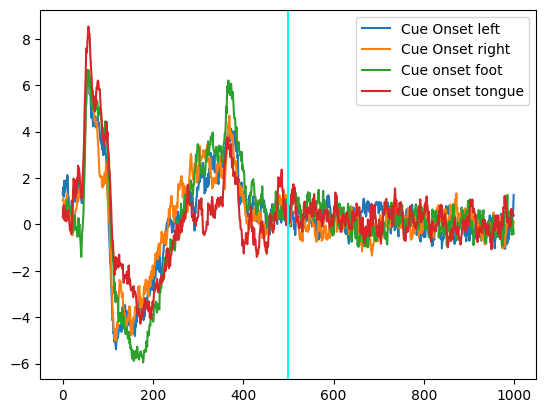

In [2]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
print(X_test.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that
# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:, 8, :]

class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0, axis=0)

class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1, axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2, axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3, axis=0)

plt.plot(np.arange(1000), avg_ch_data_class_0)
plt.plot(np.arange(1000), avg_ch_data_class_1)
plt.plot(np.arange(1000), avg_ch_data_class_2)
plt.plot(np.arange(1000), avg_ch_data_class_3)
plt.axvline(x=500, label="line at t=500", c="cyan")
plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [3]:
def train_data_prep(
    X, y, sub_sample, average, noise
):  # preparation for training samples - Subsampling, Averaging, Noise - data augmentation
    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:, :, 0:800]  # downsampling is equivalent to LPF because Nyquist
    print("Shape of X after trimming:", X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)

    total_X = X_max
    total_y = y
    print("Shape of X after maxpooling:", total_X.shape)

    # Averaging + noise
    X_average = np.mean(
        X.reshape(X.shape[0], X.shape[1], -1, average), axis=3
    )  # LPF (mean-pooling)
    X_average = X_average + np.random.normal(
        0.0, 0.5, X_average.shape
    )  # noise for regularization

    total_X = np.vstack(
        (total_X, X_average)
    )  # 2100 samples -> 4200 samples (data augmentation)
    total_y = np.hstack((total_y, y))

    print("Shape of X after averaging+noise and concatenating:", total_X.shape)

    # Subsampling

    for i in range(sub_sample):
        X_subsample = X[:, :, i::sub_sample] + (
            np.random.normal(0.0, 0.5, X[:, :, i::sub_sample].shape) if noise else 0.0
        )

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))

    print("Shape of X after subsampling and concatenating:", total_X.shape)
    print("Shape of Y:", total_y.shape)
    return total_X, total_y


def test_data_prep(X):  # prep the test data
    total_X = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:, :, 0:800]
    print("Shape of X after trimming:", X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)

    total_X = X_max
    print("Shape of X after maxpooling:", total_X.shape)

    return total_X

In [4]:
## Preprocessing the dataset

# X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True) #train and validation data
print("Test data prep")
x_test = test_data_prep(X_test)  # this is fine, no data leakage

x_train = X_train_valid
y_train = y_train_valid
print("Shape of training set:", x_train.shape)
print("Shape of training labels:", y_train.shape)

## Random splitting and reshaping the data
# data leakage
# should split into train/val AND THEN do data augmentation
# otherwise we get correlation between training and validation data (model already knows the label from the training)
print("Training data prep")
x_train, y_train = train_data_prep(
    x_train, y_train, 2, 2, False
)  # these are now x_train_prep and y_train_prep

print("Categorical conversion (one-hot encoding)")
# Converting the labels to categorical variables for multiclass classification
NUM_CLASSES = 4
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test.copy(), NUM_CLASSES)
print("Shape of training labels after categorical conversion:", y_train.shape)
print("Shape of test labels after categorical conversion:", y_test.shape)

print("Model expects shape (batch size, sequence length, features)")
# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1, 2)
x_test = np.swapaxes(x_test, 1, 2)
print("Shape of training set after dimension reshaping:", x_train.shape)
print("Shape of test set after dimension reshaping:", x_test.shape)

Test data prep
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of training set: (2115, 22, 1000)
Shape of training labels: (2115,)
Training data prep
Shape of X after trimming: (2115, 22, 800)
Shape of X after maxpooling: (2115, 22, 400)
Shape of X after averaging+noise and concatenating: (4230, 22, 400)
Shape of X after subsampling and concatenating: (8460, 22, 400)
Shape of Y: (8460,)
Categorical conversion (one-hot encoding)
Shape of training labels after categorical conversion: (8460, 4)
Shape of test labels after categorical conversion: (443, 4)
Model expects shape (batch size, sequence length, features)
Shape of training set after dimension reshaping: (8460, 400, 22)
Shape of test set after dimension reshaping: (443, 400, 22)


In [7]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    return keras.Model(inputs, outputs)


input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=128,
    num_heads=4,
    ff_dim=3,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.1,
    dropout=0.1,
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["categorical_accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
)

model.save(f"transformer-{datetime.now().isoformat()}.keras")
model.evaluate(x_test, y_test, verbose=1)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 400, 22)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 400, 22)   │      9,122 │ input_layer_2[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 400, 22)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 400, 22)   │         44 │ dropout_27[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 400, 22)   │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 400, 4)    │         92 │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 400, 4)    │          0 │ conv1d_16[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 400, 22)   │        110 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 400, 22)   │         44 │ conv1d_17[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 400, 22)   │          0 │ layer_normalizat… │
│                     │                   │            │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 400, 22)   │      9,122 │ add_17[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 400, 22)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 400, 22)   │         44 │ dropout_30[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 400, 22)   │          0 │ layer_normalizat… │
│                     │                   │            │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 400, 4)    │         92 │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 400, 4)    │          0 │ conv1d_18[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 400, 22)   │        110 │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 400, 22)   │         44 │ conv1d_19[0][0]   │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 29,968 (117.06 KB)

 Trainable params: 29,968 (117.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 343s 3s/step - categorical_accuracy: 0.2620 - loss: 1.5731 - val_categorical_accuracy: 0.2790 - val_loss: 1.4164
Epoch 2/10
 22/106 ━━━━━━━━━━━━━━━━━━━━ 4:39 3s/step - categorical_accuracy: 0.2488 - loss: 1.4947

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(model.history["accuracy"])
plt.plot(model.history["val_accuracy"])
plt.title("Hybrid CNN-LSTM model accuracy trajectory")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

# Plotting loss trajectory
plt.plot(model.history["loss"], "o")
plt.plot(model.history["val_loss"], "o")
plt.title("Hybrid CNN-LSTM model loss trajectory")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

# data leakage
# should split into train/val AND THEN do data augmentation
# otherwise we get correlation between training and validation data (model already knows the label from the training)

In [ ]:
## Testing the hybrid CNN-LSTM model

score = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy of the transformer model:", score[1])